In [3]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path

In [4]:
from   desimodel.focalplane  import get_tile_radius_deg 

In [5]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [6]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [7]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf
    dat   = Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')    
    
    return dat

In [8]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [9]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [10]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [11]:
def get_clauds(imaging_bit=1, field='COSMOS'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']
    
    clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/October2020/{}_v3_v201026.fits'.format(field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]

    # Randomise the rows for security. 
    indices       = np.arange(len(clauds[field]))
    randomised    = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [12]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [13]:
# hiz  = laigle()

In [14]:
# kids = get_kids()

In [15]:
# splash = get_splash()

In [16]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [17]:
# hilde  = get_hildebrandt()

In [18]:
# grush  = get_goldrush()

In [19]:
# laes   = get_laes()

In [20]:
# cfhtls = get_cfhtls_wide()

In [21]:
# vvds   = get_vvds()

In [22]:
clauds, area = get_clauds(imaging_bit=1, field='COSMOS')

In [23]:
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
4602225,151.09767254432563,1.8874444780207669,9814,"7,2",0,7,True .. False,0.00013891315,0.00011518431,4.0,-68.28183,1.2058667,0.17072093,0.02493293390475341,0.00037563557,25.102394,0.4629312455654144,1.1706458,1.7013791,2.1904209,26.215,25.926,25.223,24.897,24.956,24.611,24.611,-99.03,-99.022,-99.014,-99.009,0.065,0.132,0.037,0.048,0.057,0.067,0.177,-99.0,-99.0,-99.0,-99.0,26.588055,26.278055,25.543043,25.086622,25.15704,24.791077,24.85196,1e+20,1e+20,1e+20,1e+20,0.06279921,0.12495595,0.03499469,0.040481817,0.050213728,0.05833243,0.16353334,1e+20,1e+20,1e+20,1e+20,127.0,-20.054,-20.185,-21.184,-21.413,-21.969,-22.132,-22.254,-22.365,-22.413,-22.417,-22.389,-22.478,-22.261,-99.0,2.3778,2.2793,2.5744,7,1.48027,7.06863,1.92275,32,53,20,2.4054,2.2924,2.5371,0.04,2.54,10,404154000.0,0.1,1,360196000.0,9.89368,10.1292,9.4494,10.449,1.26784,0.557876,1.13256,1.74404,-8.55405,-9.57134,-9.38909,-7.92566,9.85537,9.98997,9.07085,0.0,0,2.4054
4155279,149.88748230272736,2.4001407035045883,9813,"6,5",0,63,True .. True,8.8248235e-05,6.5947956e-05,0.0,0.94967514,1.338166,0.25270855,0.016238588211874298,0.00045682827,26.762886,0.3511597812175751,1.0754004,1.6793436,2.2106419,30.819,29.103,27.986,27.566,27.763,28.116,28.274,-99.02,26.808,-99.009,26.677,1.96,0.341,0.106,0.1,0.131,0.291,0.643,-99.0,0.332,-99.0,0.627,30.45304,30.91885,27.628935,27.028408,27.303988,28.41546,99.0,99.0,26.69994,99.0,27.717472,2.5172153,3.2758923,0.1402218,0.11296985,0.16070248,0.7238679,99.0,99.0,0.57237095,99.0,3.1396677,1407.0,-17.941,-17.716,-18.088,-18.254,-18.611,-18.631,-18.663,-18.709,-18.714,-18.7,-18.609,-18.619,-18.328,-99.0,3.04,2.7865,3.2279,9,3.92921,8.21167,2.92205,28,147,19,2.9836,2.7807,3.1617,-99.0,3.0,1,286119000.0,0.0,0,508461000.0,8.39736,8.40862,7.91683,8.82165,-0.316973,-0.645813,-0.466485,0.0446745,-8.63526,-9.05444,-9.13019,-8.05947,8.51417,8.44786,7.48435,0.0,0,2.9836
2625225,

In [24]:
print('Target density of clauds galaxies per sq. deg. is {:.2f}'.format(len(clauds) / area['u']))

Target density of clauds galaxies per sq. deg. is 585624.94


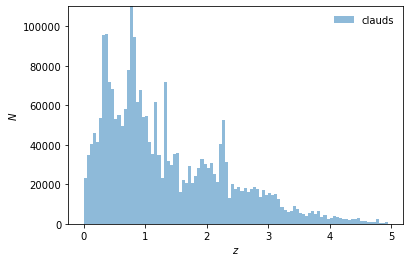

In [25]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(clauds['Z_BEST'], bins=bins, alpha=0.5, label='clauds')

pl.ylim(0.0, 1.1e5)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [26]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [27]:
tileids = np.unique(indx)

In [28]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [29]:
# u-band imaging restricted.
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [30]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

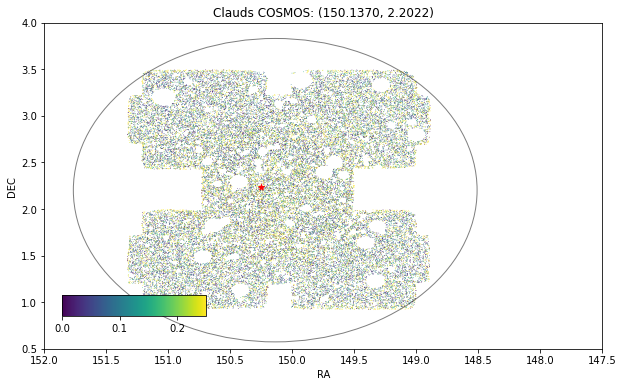

In [31]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('clauds_field.pdf')

In [32]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    
    return  isin

In [33]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [34]:
udrops    = clauds[liu_udrops(clauds)]

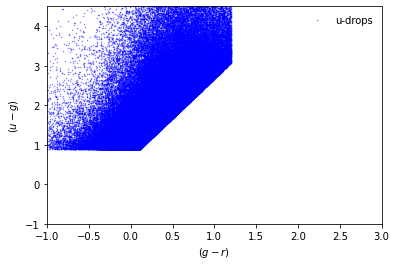

In [35]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('clauds-udrop-color-selection.pdf')

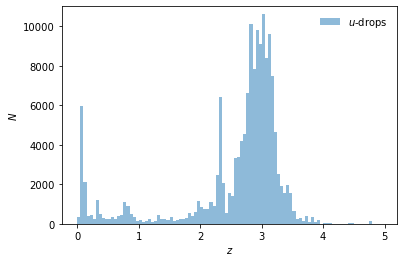

In [36]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [37]:
zmax       = 1.5
interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

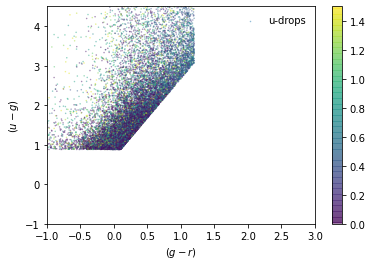

In [38]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

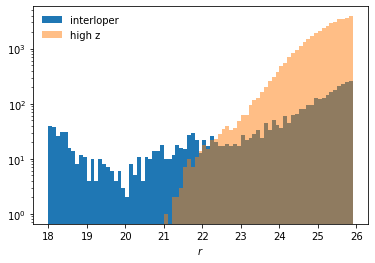

In [39]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')

pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [40]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=19., maglim=26.)]

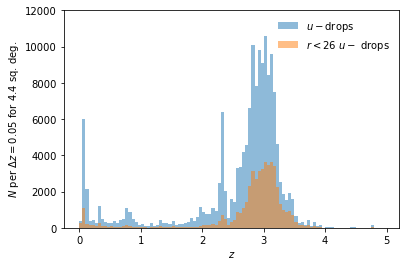

In [41]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('clauds-udrop-redshift-distribution.pdf')

In [42]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 11001.59


In [43]:
print('u-dropout interloper percentage of {:.3f}'.format(100. * np.count_nonzero(rlim_udrops['ZPHOT'] < 0.1) / len(rlim_udrops)))

u-dropout interloper percentage of 1.451


In [44]:
def flatmagcat(maglimcat, band, maglim=26.01, debug=False):
    bins       = np.arange(20., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    
    if debug:
        print(magsampling)
    
    magsampling                    = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]
        
    # In, residual.
    return  cutlim, maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

In [45]:
def qa(tiers, band, area):
    upriority, cnts = np.unique(tiers['PRIORITY'].data, return_counts=True)

    for p, c in zip(upriority[::-1], cnts[::-1]):
        magmin      = tiers[tiers['PRIORITY'] == p][band].min()
        meanmag     = np.mean(tiers[tiers['PRIORITY'] == p][band])
        meanz       = np.mean(tiers[tiers['PRIORITY'] == p]['Z_BEST'])
        
        quarter     = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 25, axis=0)
        medianz     = np.median(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed())
        tquarter    = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 75, axis=0)   
        
        loper_rate  = 100. * np.count_nonzero(tiers[tiers['PRIORITY'] == p]['Z_BEST'] < 1.5) / len(tiers[tiers['PRIORITY'] == p]) 
        
        print('{: 10d} \t {: .1f} per sq. deg. \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f} \t {:.2f} \t {:.2f}) \t {:.2f}% z < 1.5 contamination'.format(p, c / area, magmin, meanmag, meanz, quarter, medianz, tquarter, loper_rate))

In [126]:
def reduce(start_id, inputcat, band, ttype, area, maglim=26.1, levels=10, max_inpriority=500, priority_shift=0, reprioritise=True, write=False, debug=False):
    bins = np.arange(18., maglim, 0.1)
    result = pl.hist(inputcat[band], bins=bins, alpha=0.3)
    reducecat = Table(inputcat, copy=True)

    tiers = Table()
    total =  0

    for i in np.arange(levels):    
        priority                = 1000 * (levels - i) + priority_shift
        
        cutlim, flat_drops, reducecat = flatmagcat(reducecat, band, debug=debug, maglim=maglim)
        
        flat_drops['PRIORITY'] = priority
                    
        tiers                   = vstack((tiers, flat_drops))
    
        total                  += len(flat_drops)
    
        string = '{:.1f} \t {} \t {:d}'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority))

        # Reshuffle such that there's a max of 1000 to a priority class.
        # Move remaining to a lower tier.
        if np.count_nonzero(tiers['PRIORITY'] == priority) > max_inpriority:
            is_priority        = tiers['PRIORITY'] == priority

            n_priority         = np.cumsum(is_priority)

            is_priority[n_priority < (1 + max_inpriority)] = False  
        
            string += '\tAdjusting {:d} entries.'.format(len(tiers['PRIORITY'][is_priority]))
        
            if reprioritise:
                tiers['PRIORITY'][is_priority] -= 1000
    
            else:
                tiers['PRIORITY'][is_priority]  = -tiers['PRIORITY'][is_priority] 
    
        print(string)
        print('{:.1f} \t {} \t {:d}\n'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority)))
    
        result = pl.hist(tiers[tiers['PRIORITY'] == priority][band], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
    
    print('\n-------------------------\n')
    print('{} \t {}'.format(total, len(inputcat)))

    pl.xlim(18., 26.1)

    pl.xlabel(r'${}$'.format(band))
    pl.ylabel(r'$N$')

    pl.yscale('log')

    pl.legend(frameon=False, ncol=2)
    pl.title(r'${}$-drop'.format(ttype))
    pl.savefig('clauds-{}drop-magnitude-distribution.pdf'.format(ttype))
    
    isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

    tiers['TILEID']       = tiles['TILEID'][indx]
    
    tiers['SAMPLE']       = 'CLAUDS-{}'.format(ttype.upper())
    tiers['TARGETID']     = start_id + np.arange(len(tiers))
    tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

    tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
    tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

    tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
    tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

    tiers.meta['EXTNAME'] = 'MTL'

    del tiers['ISIN']
    
    if write:
        Path('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
        upriorities = np.unique(tiers['PRIORITY'])
        
        for up in upriorities:
            ptiers  = tiers[tiers['PRIORITY'] == up] 
            ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

    print('\n\n')
            
    qa(tiers, band, area)
        
    print('\n\n')
        
    return tiers

21.3 	 1 	 1006	Adjusting 506 entries.
21.3 	 2 	 500

23.0 	 3 	 2050	Adjusting 1550 entries.
23.0 	 4 	 500

23.8 	 5 	 5966	Adjusting 5466 entries.
23.8 	 6 	 500

24.2 	 7 	 7516	Adjusting 7016 entries.
24.2 	 8 	 500

24.5 	 9 	 6889	Adjusting 6389 entries.
24.5 	 10 	 500

24.7 	 11 	 5314	Adjusting 4814 entries.
24.7 	 12 	 500

24.9 	 13 	 4001	Adjusting 3501 entries.
24.9 	 14 	 500

25.0 	 15 	 2328	Adjusting 1828 entries.
25.0 	 16 	 500

25.1 	 17 	 1883	Adjusting 1383 entries.
25.1 	 18 	 500

25.2 	 19 	 1701	Adjusting 1201 entries.
25.2 	 20 	 500

25.3 	 21 	 1352	Adjusting 852 entries.
25.3 	 22 	 500

25.4 	 23 	 754	Adjusting 254 entries.
25.4 	 24 	 500

25.5 	 25 	 487
25.5 	 25 	 487

25.6 	 26 	 568	Adjusting 68 entries.
25.6 	 27 	 500

25.7 	 28 	 624	Adjusting 124 entries.
25.7 	 29 	 500

25.7 	 30 	 188
25.7 	 30 	 188

25.8 	 31 	 577	Adjusting 77 entries.
25.8 	 32 	 500

25.8 	 33 	 182
25.8 	 33 	 182

25.8 	 34 	 114
25.8 	 34 	 114


------------------

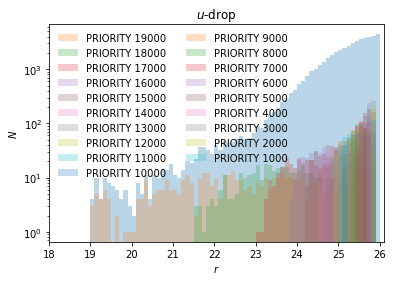

In [175]:
utiers = reduce(0, rlim_udrops, 'r', 'u', area['u'], reprioritise=False, maglim=26.01, levels=19, write=False)

# BX selection

In [116]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [117]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

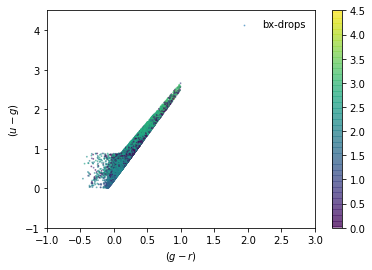

In [118]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

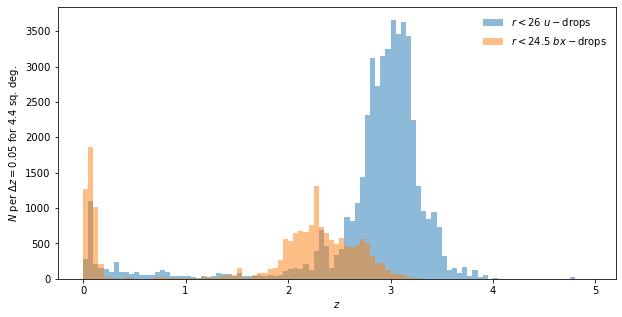

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
axes.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [120]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3970.75


In [121]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [122]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 12.786


Text(0, 0.5, '$(u-g)$')

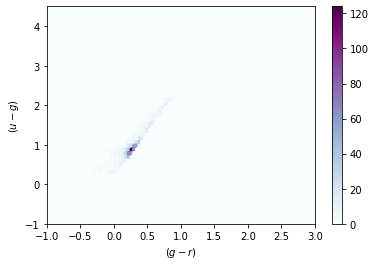

In [123]:
plt.hexbin(bx_interlopers['g'] - bx_interlopers['r'], bx_interlopers['u'] - bx_interlopers['g'], label='bx-drops', extent=[-1., 3., -1., 4.5], cmap='BuPu')
pl.colorbar()

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

In [141]:
start_id = len(utiers)
start_id

43515

20.0 	 1 	 2950	Adjusting 2450 entries.
20.0 	 2 	 500

22.3 	 3 	 737	Adjusting 237 entries.
22.3 	 4 	 500

23.0 	 5 	 1390	Adjusting 890 entries.
23.0 	 6 	 500

23.4 	 7 	 2205	Adjusting 1705 entries.
23.4 	 8 	 500

23.6 	 9 	 2054	Adjusting 1554 entries.
23.6 	 10 	 500

23.7 	 11 	 1232	Adjusting 732 entries.
23.7 	 12 	 500

23.8 	 13 	 941	Adjusting 441 entries.
23.8 	 14 	 500

23.9 	 15 	 840	Adjusting 340 entries.
23.9 	 16 	 500

24.0 	 17 	 713	Adjusting 213 entries.
24.0 	 18 	 500

24.1 	 19 	 520	Adjusting 20 entries.
24.1 	 20 	 500

24.2 	 21 	 515	Adjusting 15 entries.
24.2 	 22 	 500

24.2 	 23 	 150
24.2 	 23 	 150

24.3 	 24 	 350
24.3 	 24 	 350

24.3 	 25 	 105
24.3 	 25 	 105

24.3 	 26 	 60
24.3 	 26 	 60

24.4 	 27 	 321
24.4 	 27 	 321


-------------------------

15083 	 17511



     19000 	  113.4 per sq. deg. 	 19.00 	 21.71 	 0.72 	 (0.06 	 0.09 	 1.97) 	 71.60% z < 1.5 contamination
     18000 	  113.4 per sq. deg. 	 20.02 	 23.17 	 1.56 	 (0.11 	 2.1

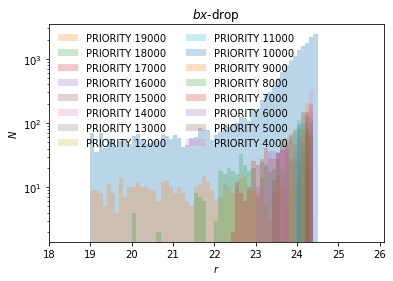

In [182]:
bxtiers = reduce(start_id, bx_clauds, 'r', 'bx', area['u'], levels=16, priority_shift=3000, maglim=24.51, reprioritise=False, debug=False, write=False)

In [183]:
bxtiers[bxtiers['PRIORITY'] >= 0]

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
4195824,149.96138441952732,2.7349397424298587,9813,"6,7",0,31,True .. True,0.0001654596,0.00014144724,4.0,-37.046837,1.1698143,0.14516348,0.017879956315066295,0.0004184207,24.453085,0.6657947897911072,1.1720123,1.7580702,2.3086064,26.408,26.388,24.894,24.348,24.203,24.064,24.047,24.12,23.925,23.492,23.299,0.161,0.116,0.021,0.017,0.016,0.023,0.044,0.096,0.102,0.089,0.131,26.99897,26.891684,25.331484,24.753325,24.604565,24.492344,24.489332,24.606602,24.387363,23.946991,23.717674,0.15890715,0.104679905,0.018706718,0.0145802675,0.013736681,0.020477407,0.04008774,0.09055607,0.09509798,0.082367584,0.118366025,2047.0,-21.076,-21.392,-21.835,-21.818,-22.079,-22.282,-22.459,-22.607,-22.678,-22.697,-22.774,-22.863,-22.611,-99.0,2.8906,2.8541,2.9294,11,2.91441,29.9805,14.7373,33,143,26,2.9051,2.8602,2.9578,-99.0,2.94,9,50000000.0,0.3,1,116993000.0,9.80649,9.8376,9.66759,9.87197,1.75747,2.21427,1.64932,2.22415,-7.95831,-7.62333,-8.13919,-7.57883,10.9597,10.3895,9.29227,0.0,0,2.9051,1.514000000000003,0.5459999999999994,19000,11155,CLAUDS-BX,58598,0.738492735428322,0.0,0.0,0.0,0.0
4343232,149.6439299196272,2.7786574383197693,9813,"7,7",0,31,True .. True,0.00020330843,0.0001779028,4.0,-81.69358,1.1428092,0.12496328,0.015970291307947665,0.0001860225,20.461174,0.9824323654174804,0.8856545,1.360818,1.7804291,22.022,21.898,21.219,20.959,20.908,20.891,20.852,20.925,21.018,21.225,21.582,0.004,0.005,0.002,0.002,0.002,0.003,0.006,0.009,0.013,0.021,0.052,22.306366,22.243889,21.520538,21.195223,21.113958,21.067398,21.101799,21.26936,21.30291,21.476908,21.828196,0.0015663434,0.002163598,0.00081599934,0.0007497046,0.0007322609,0.0011463002,0.0023501646,0.0042919545,0.0057614907,0.008875619,0.0221521,2047.0,-14.581,-14.621,-15.35

# Goldrush g-dropouts

In [143]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [144]:
def gdrop(cat, imin=18., imax=26.):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
    
    # Exclude where we have u imaging
    isin = isin & (cat['FLAG_FIELD_BINARY'][:,1] == False)
        
    return  isin

In [145]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,u,uS,g,r,i,z,y,Yv,J,H,Ks,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,ZPHOT
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
3034543,148.81276699656175,1.6242189354891303,9812,"4,1",0,1,True .. False,9.960309e-05,8.324593e-05,6.199142,-14.7059,1.1964368,0.16418481,0.01957369676421286,0.00051711855,25.645098,0.216278538107872,0.45770013,0.66965246,0.8255838,-99.094,25.443,29.505,28.35,28.489,27.86,28.005,-99.024,-99.017,-99.011,-99.007,-99.0,1000.0,0.298,0.118,0.191,0.16,0.435,-99.0,-99.0,-99.0,-99.0,1e+20,99.0,28.20648,26.503675,26.80557,26.217697,26.070595,1e+20,1e+20,1e+20,1e+20,1e+20,99.0,0.5833958,0.14187132,0.26923344,0.23733367,0.49334744,1e+20,1e+20,1e+20,1e+20,126.0,-16.986,-17.56,-18.343,-18.475,-18.94,-19.264,-19.49,-19.657,-19.709,-19.716,-19.716,-19.693,-19.467,-99.0,3.5618,0.2981,3.8874,6,0.935425,2.42398,0.376379,1,79,1,2.8589,0.3857,3.6472,0.38,0.36,9,9999980.0,0.5,1,430598000.0,9.17654,8.50601,8.51974,9.8259,0.637916,1.52754,0.0887759,1.19538,-8.55682,-6.97847,-9.13707,-7.97469,10.0415,9.36138,7.95157,0.0,0,2.8589
2325113,150.93600107022692,1.281906484803051,9571,"5,7",0,7,True .. False,0.00016304148,0.00010892874,4.0,70.59127,1.4968063,0.3319109,0.022707908937867977,0.0007994558,25.694544,0.6461254954338074,0.9804299,1.5193026,1.9764996,26.426,26.503,25.959,25.677,25.759,25.758,25.378,-99.027,-99.02,-99.013,-99.008,0.073,0.331,0.064,0.076,0.106,0.167,0.302,-99.0,-99.0,-99.0,-99.0,26.65298,26.710287,26.26885,25.978127,26.199316,26.01232,25.717098,1e+20,1e+20,1e+20,1e+20,0.07001041,0.31312233,0.06806232,0.08183741,0.13132165,0.17612733,0.34644663,1e+20,1e+20,1e+20,1e+20,127.0,-18.956,-19.186,-19.769,-19.992,-20.477,-20.543,-20.586,-20.658,-20.714,-20.722,-20.698,-20.769,-20.516,-99.0,0.04,0.04,2.2756,7,0.340924,3.73954,0.532186,33,241,28,2.1592,0.2084,2.4318,2.24,0.96,19,404154000.0,0.0,0,445836000.0,9.32921,9.43381,8.85605,9.85181,0.813239,-0.139859,0.394377,0.966724,-8.6004,-9.57367,-9.22658,-7.9519,9.07964,9.24313,8.38862,0.0,0,2.1592
2169481,151.29900782770954,1.3

In [146]:
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=26.)]

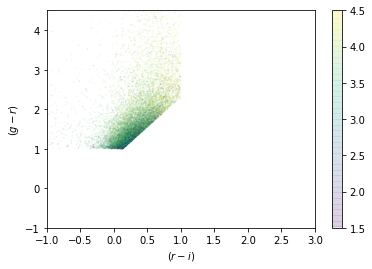

In [147]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

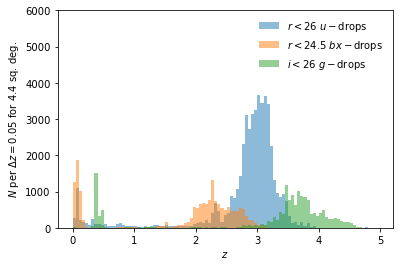

In [148]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')
pl.hist(ilim_gdrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$i<26 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [149]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / (area['g'] - area['u'])))

Target density of g-dropouts per sq. deg. is 4717.78


In [150]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BEST'] < 1.0) / len(ilim_gdrops)))

g-drop interloper percentage of 15.344


In [151]:
start_id = 1 + bxtiers['TARGETID'].max()
start_id

58598

<ipython-input-44-e0faa87aba60>:20: RuntimeWarning: divide by zero encountered in true_divide
  magsampling                    = 1. / magsampling


20.1 	 1 	 220
20.1 	 1 	 220

23.4 	 2 	 667
23.4 	 2 	 667

24.1 	 3 	 2003	Adjusting 1003 entries.
24.1 	 4 	 1000

24.5 	 5 	 2464	Adjusting 1464 entries.
24.5 	 6 	 1000

24.7 	 7 	 1954	Adjusting 954 entries.
24.7 	 8 	 1000

24.9 	 9 	 1760	Adjusting 760 entries.
24.9 	 10 	 1000

25.0 	 11 	 1218	Adjusting 218 entries.
25.0 	 12 	 1000

25.1 	 13 	 889
25.1 	 13 	 889

25.2 	 14 	 751
25.2 	 14 	 751

25.3 	 15 	 689
25.3 	 15 	 689

25.4 	 16 	 491
25.4 	 16 	 491

25.5 	 17 	 317
25.5 	 17 	 317

25.6 	 18 	 216
25.6 	 18 	 216

25.7 	 19 	 246
25.7 	 19 	 246

25.7 	 20 	 76
25.7 	 20 	 76

25.8 	 21 	 206
25.8 	 21 	 206

25.8 	 22 	 68
25.8 	 22 	 68

25.8 	 23 	 43
25.8 	 23 	 43

25.9 	 24 	 216
25.9 	 24 	 216


-------------------------

14494 	 16182



     19000 	  28.1 per sq. deg. 	 18.38 	 23.13 	 2.44 	 (0.39 	 3.46 	 3.91) 	 40.00% z < 1.5 contamination
     18000 	  85.1 per sq. deg. 	 21.89 	 24.54 	 3.16 	 (3.36 	 3.61 	 3.89) 	 16.64% z < 1.5 contamination


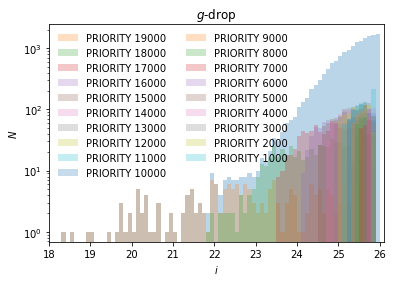

In [187]:
gtiers = reduce(start_id, ilim_gdrops, 'i', 'g', area['g'], max_inpriority=1000, priority_shift=0, maglim=26.01, reprioritise=False, levels=19, debug=False, write=False)

In [188]:
len(gtiers[gtiers['PRIORITY'] >= 0])

10095

In [190]:
for tiers, ttype in zip([utiers, bxtiers, gtiers], ['u', 'bx', 'g']):
    Path('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
    upriorities = np.unique(tiers['PRIORITY'])
        
    for up in upriorities:
        ptiers  = tiers[tiers['PRIORITY'] == up] 
        ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/final/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

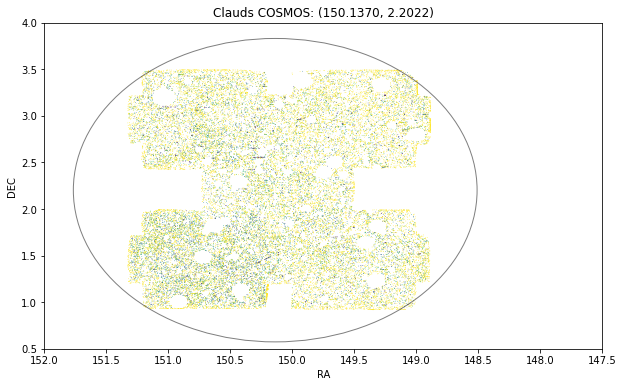

In [74]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(utiers['RA'], utiers['DEC'], c=utiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

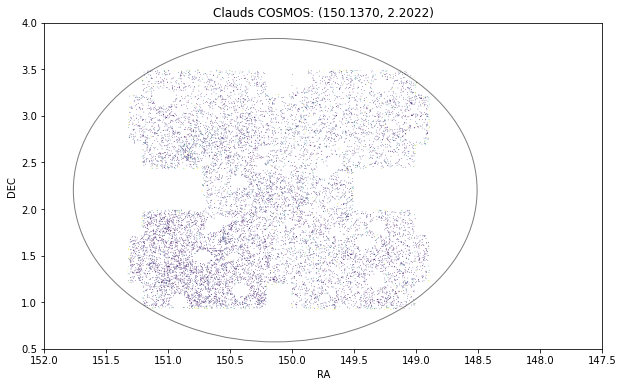

In [75]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(bxtiers['RA'], bxtiers['DEC'], c=bxtiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

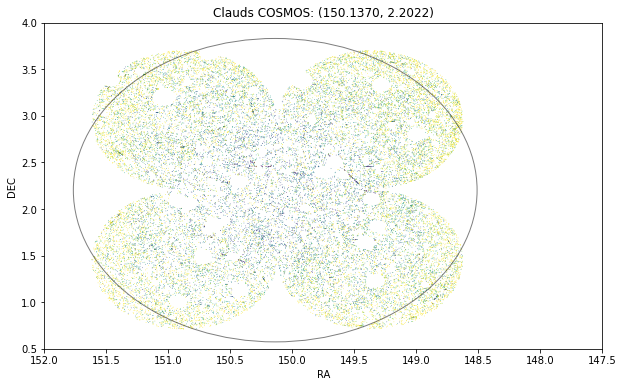

In [76]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(gtiers['RA'], gtiers['DEC'], c=gtiers['g_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

# Done.